## Heart Disease

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [5]:
##加载数据
dt=pd.read_csv("heart_disease.csv")
dt.head(10)
##数据中的字段介绍
# cp：经历过的胸痛（值1：典型心绞痛，值2：非典型心绞痛，值3：非心绞痛，值4：无症状）
# trestbps：人的静息血压（入院时的毫米汞柱）
# chol：人的胆固醇测量值，mg / dl
# fbs：该人的空腹血糖（> 120 mg / dl，1 =正确； 0 =错误）
# restecg：静息心电图测量（0 =正常，1 =患有ST-T波异常，2 =根据Estes的标准显示可能或确定的左心室肥大）
# thalach：此人达到的最大心率
# exang：运动引起的心绞痛（1 =是； 0 =否）
# oldpeak：运动引起的相对于休息的ST抑郁（“ ST”与ECG图上的位置有关。在此处查看更多）
# 斜率：最高运动ST段的斜率（值1：向上倾斜，值2：平坦，值3：向下倾斜）
# ca：主要血管的数量（0-3）
# thal：一种称为地中海贫血的血液疾病（3 =正常； 6 =固定缺损； 7 =可逆缺损）
# 目标：心脏病（0 =否，1 =是）


#查询到的一些站外关禹心脏病的资料
# 为避免发生混响（或得知结果后出现混乱），我将看一下有关如何诊断心脏病的在线指南，并查找上述一些术语。

# 诊断：心脏病的诊断是结合临床体征和测试结果进行的。运行测试的类型将根据医生的想法进行选择1，从心电图和心脏计算机断层扫描（CT）扫描到血液测试和运动压力测试2。

# 查看心脏病的危险因素信息，可以得出以下结论：高胆固醇，高血压，糖尿病，体重，家族史和吸烟3.根据另一资料来源4，无法改变的主要因素是：年龄增长，男性性别和遗传。请注意，地中海贫血是该数据集的变量之一，是遗传。可以改变的主要因素是：吸烟，高胆固醇，高血压，缺乏运动，超重和患有糖尿病。其他因素包括压力，酒精和不良饮食/营养。

# 我看不到“主要血管的数量”，但考虑到心脏病的定义是“ ...当心脏的血液供应被冠状动脉中的脂肪物质堆积阻塞或中断时，会发生什么情况？他说：“看来，越多的大血管是一件好事，因此将减少患心脏病的可能性，这是合乎逻辑的。

# 鉴于以上所述，我将假设，如果模型具有一定的预测能力，我们将认为这些因素最为重要。

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [7]:

#根据以上信息筛选出有用的列，直接用columns来筛选出需要的列
dt.columns=['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']
dt

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [13]:
#将0,1等指标换成容易懂的信息
dt['sex'][dt['sex']==0]='female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'
dt
dt.dtypes##发现有些类型是不正确的

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [15]:
##利用astpe来改变其数据类型
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [20]:
#首先感知一下dget_dummies的使用，本质上是oe_hot，去掉第一列的作用是避免列数太多，比如男女，非男即女
pd.get_dummies(dt['sex'],drop_first=True)
pd.get_dummies(dt['rest_ecg'],drop_first=True)

,left ventricular hypertrophy,normal
0,0,1
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
298,0,0
299,0,0
300,0,0
301,0,0


In [21]:
dt=pd.get_dummies(dt,drop_first=True)
dt.head(10)

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0
5,57,140,192,148,0.4,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0
6,56,140,294,153,1.3,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0
7,44,120,263,173,0.0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1
8,52,172,199,162,0.5,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1
9,57,150,168,174,1.6,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0


In [23]:
#the model,分割训练集，测试集及目标标签
x_train,x_test,y_train,y_test=train_test_split(dt.drop('target',1),dt['target'],test_size=0.2,random_state=10)



In [28]:
##训练集测试模型
model=RandomForestClassifier(max_depth=5)
model.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

混淆矩阵和sensitivety(灵敏度，也称之为召回率），specificity(特异性）
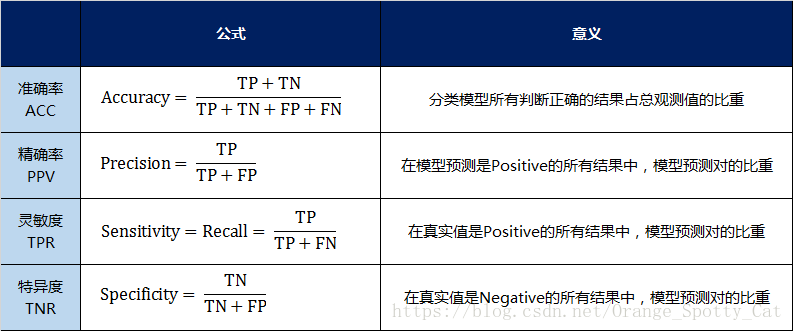



In [29]:
y_predict=model.predict(x_test)
confusion_matrix=confusion_matrix(y_test,y_predict)
confusion_matrix




array([[27,  8],
       [ 4, 22]], dtype=int64)

In [36]:
##根据上述的sensitivity/specificity 描述，进行计算
total=sum(sum(confusion_matrix))#总数
sensitivity=confusion_matrix[0][0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )
specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

###正例的准确率为87%，反例为73%


Sensitivity :  0.8709677419354839
Specificity :  0.7333333333333333


ROC曲线的讲解
ROC曲线的横轴为1-specificity,纵轴为sensitivity
AUC即ROC曲线和横轴围成的面积，该面积0.5<AUC<1,越接近1模型越好，AUC=0.5类似于扔硬币，模型没有预测能力，AUC小于0.5
表示模型效果比随机猜测还差
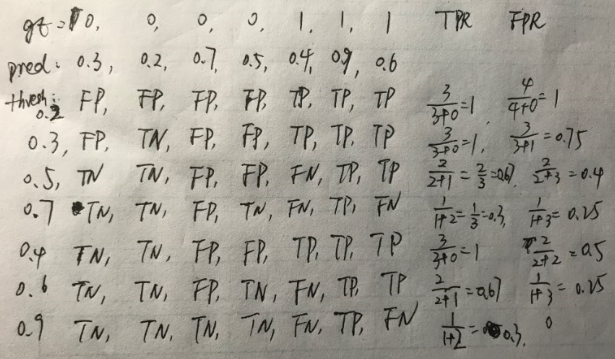


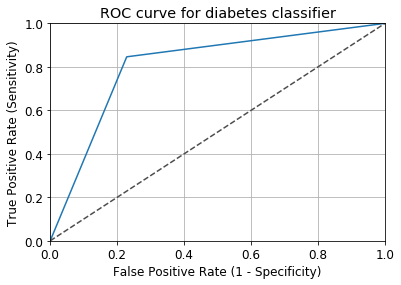

In [43]:
##根据上边的计算方式绘制ROC曲线
fpr,tpr,thresholds=roc_curve(y_test,y_predict)##横轴fpr(1-Specificity ),纵轴为tpr
fig,ax=plt.subplots()
ax.plot(fpr,tpr)
ax.plot([0,1],[0,1],transform=ax.transAxes,ls='--',c='.3')#绘制斜对角线
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.rcParams['font.size'] = 12
plt.grid(True)##添加网格线
plt.show()


In [44]:
##计算上图的AUC值
auc(fpr,tpr)##80%---good
# 0.90 - 1.00 = excellent
# 0.80 - 0.90 = good
# 0.70 - 0.80 = fair
# 0.60 - 0.70 = poor
# 0.50 - 0.60 = fail

0.8087912087912088

下面我们来尝试解释一下模型
<span class="burk">Permutation importance</span> is the first tool for understanding a machine-learning model

可以看到每一个特征在模型中的占比权重

In [46]:
perm=PermutationImportance(model,random_state=1).fit(x_test,y_test)
eli5.show_weights(perm,feature_names=x_test.columns.tolist())

Weight,Feature
0.0197 ± 0.0382,thalassemia_fixed defect
0.0164 ± 0.0000,chest_pain_type_non-anginal pain
0.0098 ± 0.0161,thalassemia_reversable defect
0.0098 ± 0.0262,st_depression
0.0098 ± 0.0262,exercise_induced_angina_yes
0 ± 0.0000,fasting_blood_sugar_lower than 120mg/ml
0 ± 0.0000,max_heart_rate_achieved
0 ± 0.0000,thalassemia_normal
0 ± 0.0000,chest_pain_type_typical angina
0 ± 0.0000,rest_ecg_left ventricular hypertrophy


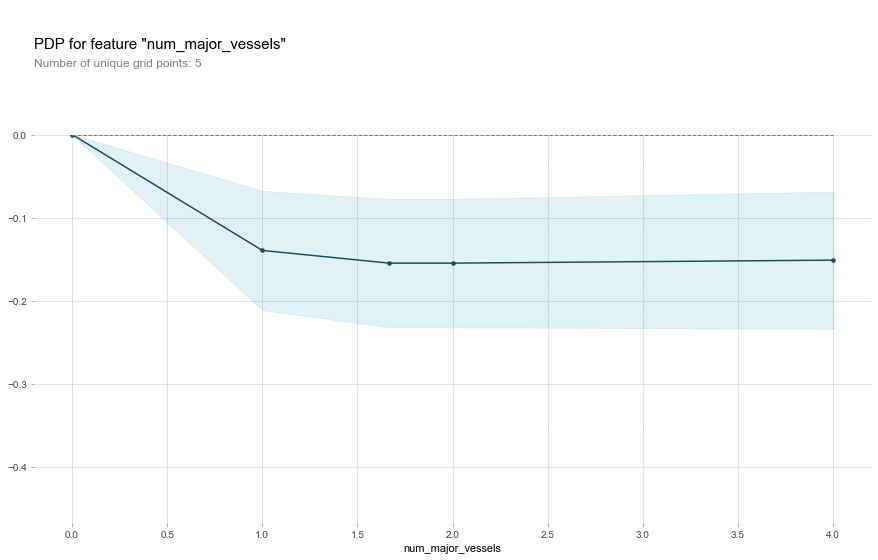

In [53]:
base_features=dt.columns.values.tolist()
##如果写成dt.columns 则返回type是index,加上values 返回的是array类型，然后用tolist 转化为列表类型
base_features.remove('target')
feat_name = 'num_major_vessels'
pdp_model=pdp.pdp_isolate(model=model,dataset=x_test,model_features=base_features,feature=feat_name)
##如果想要知道单个因素中的值预测结果，就用该方法，第一个参数为上述训练模型，第二个参数为测试集，第三个参数为测试集中的特征
pdp.pdp_plot(pdp_model,feat_name)#第二个参数为要单独分析的特征
plt.show()#全部为负值



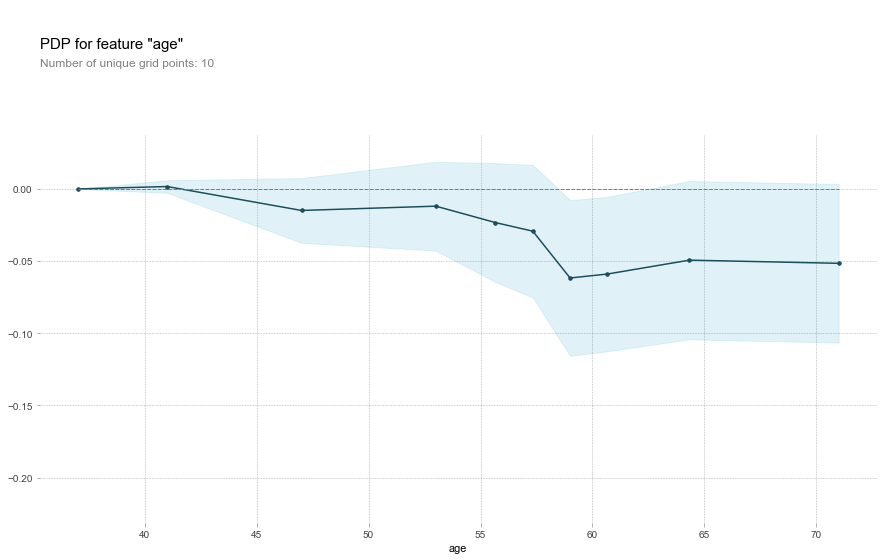

In [54]:
##看一下年龄
base_features=dt.columns.values.tolist()
##如果写成dt.columns 则返回type是index,加上values 返回的是array类型，然后用tolist 转化为列表类型
base_features.remove('target')
feat_name = 'age'
pdp_model=pdp.pdp_isolate(model=model,dataset=x_test,model_features=base_features,feature=feat_name)
##如果想要知道单个因素中的值预测结果，就用该方法，第一个参数为上述训练模型，第二个参数为测试集，第三个参数为测试集中的特征
pdp.pdp_plot(pdp_model,feat_name)#第二个参数为要单独分析的特征
plt.show()
##年龄越大越不容得心脏病？

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

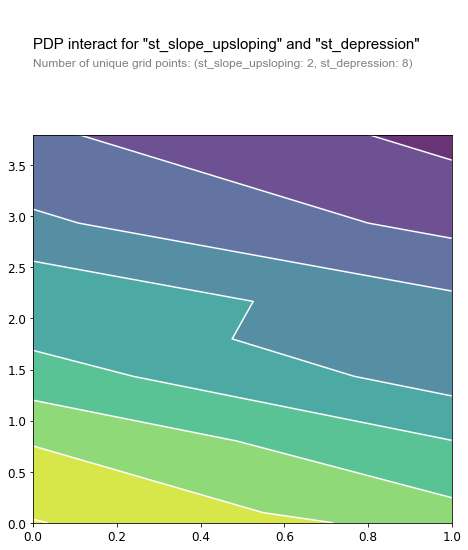

In [57]:
##根据答主的描述心脏病的因素可能不是一个因素去影响的，因此用了二维来看多个因素的相互作用
inter1  =  pdp.pdp_interact(model=model, dataset=x_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

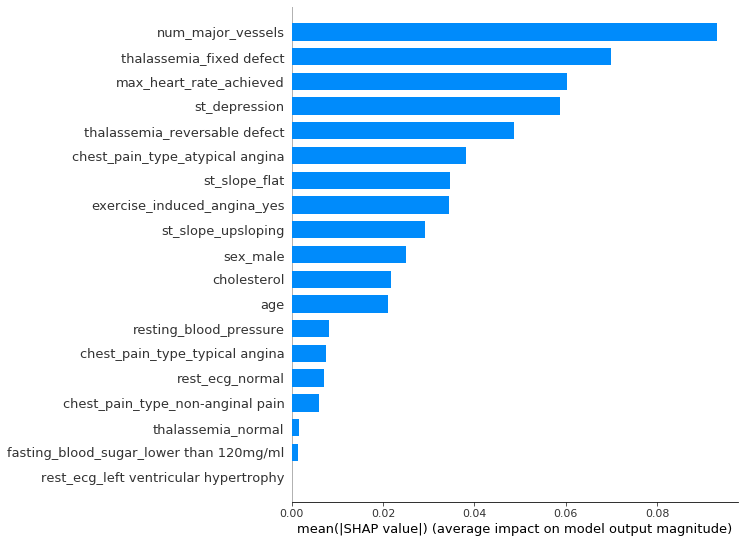

In [64]:
##来看一下每一个因素对权重的影响
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(x_test)
shap_values#输出的是一个三维数组，每一个位置上的值是该行该列的属性参数对最终预测影响的值
shap.summary_plot(shap_values[1],x_test,plot_type='bar')
